# Transfer learning of BERT/mBERT for binary classification

BERT embedding + Linear Layer & SoftMax

In [19]:
import os
import logging
import re
from pprint import pprint
from glob import glob

import pandas as pd
import numpy as np

import wandb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from scipy.special import softmax
from matplotlib import pyplot as plt
import seaborn as sns

from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [20]:
# (optional) Login to WANDB to monitor training progress
try:
    wandb.login()
except Exception as e:
    pprint(e)

In [21]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Prepare datasets

In [22]:
def clean_text(text):
    user_re = r"(@[\w]+)"
    link_re = r"(https?:\/\/\S+)"
    text = re.sub(user_re, "", text) # remove user tags
    text = re.sub(link_re, "", text) # remove links
    text = text.lower()
    return text

def load_hasoc_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    try: del data_df["text_id"]
    except: pass

    try: del data_df["task_2"]
    except: pass

    try: del data_df["task_3"]
    except: pass

    data_df.columns = ["text", "labels"]
    data_df["text"] = data_df["text"].map(clean_text)

    return data_df

def load_senti_news_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    data_df["text"] = data_df["content"].map(clean_text)
    data_df["labels"] = data_df["avg_sentiment"].map(lambda x: "NOT" if round(float(x)) >= 3 else "HOF")

    data_df = data_df.drop(columns=set(data_df.columns) - {"text", "labels"})

    return data_df

train_en_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/english/english_dataset/english_dataset.tsv")
train_de_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/german/german_dataset/german_dataset.tsv")
train_hi_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/hindi/hindi_dataset/hindi_dataset.tsv")

test_en_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/english/english_dataset/hasoc2019_en_test-2919.tsv")
test_de_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/german/german_dataset/hasoc_de_test_gold.tsv")
test_hi_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/hindi/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv")

train_si_df, test_si_df = train_test_split(load_senti_news_dataset("data/non-processed/dataset10/SentiNews_sentence-level.txt"), test_size=0.005)

train_ml_df = pd.concat([train_en_df, train_de_df, train_hi_df, train_si_df.sample(n=6000)])
test_ml_df  = pd.concat([test_en_df,  test_de_df,  test_hi_df,  test_si_df                ])

In [23]:
def plot_class_hist(data_df, title):
    data_df["labels"].value_counts().plot(kind="bar", title=f"Class distirbution: {title}")

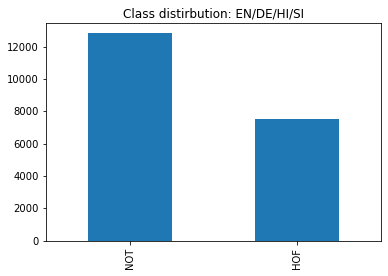

In [24]:
plot_class_hist(train_ml_df, "EN/DE/HI/SI")

Since classes are unablanced we will use class weights when training the models

## Train BERT models

In [25]:
def get_bert_model(model_name, hf_model_type, hf_model_name, class_weights=None):
    model_args = ClassificationArgs()
    model_args.output_dir=f"checkpoints/outputs/{model_name}"
    # model_args.output_dir=f"/hdd/matjazibb/outputs/{model_name}"
    # model_args.best_model_dir=f"{model_args.output_dir}/best_model"
    # model_args.cache_dir=f"/hdd/matjazibb/cache_dir/{model_name}"
    # model_args.tensorboard_dir=f"/hdd/matjazibb/runs/{model_name}"

    # Training HP
    model_args.fp16 = False
    model_args.num_train_epochs = 1
    model_args.learning_rate = 1e-5
    model_args.polynomial_decay_schedule_lr_end = 1e-7
    model_args.train_batch_size = 1 # 12GB GPU memory is not enough
    model_args.weight_decay = 1e-7
    model_args.scheduler = "polynomial_decay_schedule_with_warmup"

    # Dataset
    model_args.labels_list = ["HOF", "NOT"]

    # Evaluation
    model_args.evaluate_during_training = False
    model_args.evaluate_each_epoch = False

    # Outputs & cache
    model_args.save_model_every_epoch = True
    model_args.save_steps = -1
    model_args.overwrite_output_dir = True
    model_args.wandb_project = "eval-bert"

    need_training = not os.path.exists(model_args.output_dir)
    pretrained_model_name = hf_model_name if need_training else model_args.output_dir

    return need_training, ClassificationModel(
        hf_model_type, pretrained_model_name,
        args=model_args,
        use_cuda=True,
        cuda_device=0,
        num_labels=2,
        weight=class_weights
    )

In [26]:
def get_class_weights(df):
    return compute_class_weight('balanced', ["HOF", "NOT"], train_en_df["labels"]).tolist()

In [27]:
need_training, bert_en_model = get_bert_model(
    "bert_en",
    "bert",
    "bert-base-uncased",
    class_weights = get_class_weights(train_en_df)
)

if need_training:
    bert_en_model.train_model(train_en_df)

In [28]:
need_training, bert_ml_model = get_bert_model(
    "bert_ml",
    "bert",
    "bert-base-uncased",
    class_weights = get_class_weights(train_ml_df)
)

if need_training:
    bert_ml_model.train_model(train_ml_df)

In [29]:
need_training, mbert_en_model = get_bert_model(
    "mbert_en",
    "bert",
    "bert-base-multilingual-uncased",
    class_weights = get_class_weights(train_en_df)
)

if need_training:
    mbert_en_model.train_model(train_en_df)

In [30]:
need_training, mbert_ml_model = get_bert_model(
    "mbert_ml",
    "bert",
    "bert-base-multilingual-uncased",
    class_weights = get_class_weights(train_ml_df)
)

if need_training:
    mbert_ml_model.train_model(train_ml_df)

## Evaluate BERT models

In [31]:
def eval_model(model, data_df):
    y_true = data_df["labels"]
    y_hat, p_hat = model.predict(data_df["text"].tolist())
    p_hat = softmax(p_hat, axis=1)[:,0]

    f1 = sklearn.metrics.f1_score(y_true, y_hat, pos_label="HOF")
    precision = sklearn.metrics.precision_score(y_true, y_hat, pos_label="HOF")
    recall = sklearn.metrics.recall_score(y_true, y_hat, pos_label="HOF")
    fpr, tpr, t = sklearn.metrics.roc_curve(y_true, p_hat, pos_label="HOF")
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    return f1, precision, recall, roc_auc, fpr, tpr

In [32]:
eval_models = [
    ("BERT-HASOC-en-en",            bert_en_model,      test_en_df),
    ("BERT-HASOC-en-de",            bert_en_model,      test_de_df),
    ("BERT-HASOC-en-hi",            bert_en_model,      test_hi_df),
    ("BERT-HASOC-en-SentiNews-si",  bert_en_model,      test_si_df),

    ("mBERT-HASOC-en-en",           mbert_en_model,     test_en_df),
    ("mBERT-HASOC-en-de",           mbert_en_model,     test_de_df),
    ("mBERT-HASOC-en-hi",           mbert_en_model,     test_hi_df),
    ("mBERT-HASOC-en-SentiNews-si", mbert_en_model,     test_si_df),

    ("BERT-X-en",                   bert_ml_model,      test_en_df),
    ("BERT-X-de",                   bert_ml_model,      test_de_df),
    ("BERT-X-hi",                   bert_ml_model,      test_hi_df),
    ("BERT-X-si",                   bert_ml_model,      test_si_df),

    ("mBERT-X-en",                  mbert_ml_model,     test_en_df),
    ("mBERT-X-de",                  mbert_ml_model,     test_de_df),
    ("mBERT-X-hi",                  mbert_ml_model,     test_hi_df),
    ("mBERT-X-si",                  mbert_ml_model,     test_si_df),
]

results = []

for model_name, model, data_df in eval_models:
    f1, precision, recall, roc_auc, fpr, tpr = eval_model(model, data_df)
    results += [(model_name, f1, precision, recall, roc_auc, fpr, tpr)]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1318 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1318 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1318 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1318 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

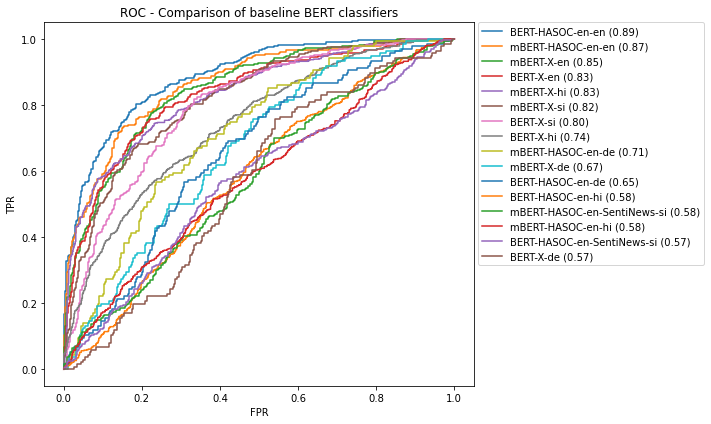

In [33]:
plt.figure(figsize=(10,6))
for model_name, f1, precision, recall, roc_auc, fpr, tpr in sorted(results, key=lambda x: x[4], reverse=True):
    plt.plot(fpr, tpr, label=f"{model_name} ({roc_auc:.2f})")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Comparison of baseline BERT classifiers")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, ncol=1)
plt.tight_layout()
plt.savefig("results/eval-bert-rocs.pdf")

In [34]:
results_df = pd.DataFrame(results, columns=["model_name", "f1", "precision", "recall", "roc_auc", "fpr", "tpr"])
results_df.to_csv("results/eval-bert.csv", index=False)
results_df.head(30)

,model_name,f1,precision,recall,roc_auc,fpr,tpr
0,BERT-HASOC-en-en,0.644243,0.513402,0.864583,0.888034,"[0.0, 0.0, 0.0, 0.0011560693641618498, 0.00115...","[0.0, 0.003472222222222222, 0.0659722222222222..."
1,BERT-HASOC-en-de,0.242623,0.218935,0.272059,0.652074,"[0.0, 0.0014005602240896359, 0.001400560224089...","[0.0, 0.0, 0.014705882352941176, 0.01470588235..."
2,BERT-HASOC-en-hi,0.013051,0.500000,0.006612,0.582100,"[0.0, 0.0, 0.0, 0.001402524544179523, 0.001402...","[0.0, 0.001652892561983471, 0.0033057851239669..."
3,BERT-HASOC-en-SentiNews-si,0.079320,0.451613,0.043478,0.570484,"[0.0, 0.0019120458891013384, 0.001912045889101...","[0.0, 0.0, 0.003105590062111801, 0.00310559006..."
4,mBERT-HASOC-en-en,0.623037,0.500000,0.826389,0.865017,"[0.0, 0.0, 0.0, 0.0011560693641618498, 0.00115...","[0.0, 0.003472222222222222, 0.1006944444444444..."
5,mBERT-HASOC-en-de,0.392157,0.294118,0.588235,0.714821,"[0.0, 0.0014005602240896359, 0.002801120448179...","[0.0, 0.0, 0.0, 0.007352941176470588, 0.007352..."
6,mBERT-HASOC-en-hi,0.375139,0.570946,0.279339,0.576893,"[0.0, 0.0, 0.0, 0.001402524544179523, 0.001402...","[0.0, 0.001652892561983471, 0.0033057851239669..."
7,mBERT-HASOC-en-SentiNews-si,0.047904,0.666667,0.024845,0.577515,"[0.0, 0.0, 0.0019120458891013384, 0.0019120458...","[0.0, 0.003105590062111801, 0.0031055900621118..."
8,BERT-X-en,0.626822,0.540201,0.746528,0.833048,"[0.0, 0.0, 0.0, 0.0011560693641618498, 0.00115...","[0.0, 0.003472222222222222, 0.0208333333333333..."
9,BERT-X-de,0.000000,0.000000,0.000000,0.566434,"[0.0, 0.0014005602240896359, 0.025210084033613...","[0.0, 0.0, 0.0, 0.007352941176470588, 0.007352..."


In [35]:
%reset